### 对eagle MPC的代码进行复现
从最简单的Hover开始

In [2]:
import numpy as np
import time
import copy
import crocoddyl

import eagle_mpc
from eagle_mpc.utils.simulator import AerialSimulator
from eagle_mpc.utils.plots import PlotControlsGroup, showPlots, Plot3DTrajectory, PlotStates

import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

### Step 1: 生成最优轨迹

In [3]:
# Trajectory
dt = 50  #! ms  trajectory的时间步长
useSquash = True
robotName = 'hexacopter370_flying_arm_3'
# trajectoryName = 'eagle_catch_nc'
# trajectoryName = 'displacement'
# trajectoryName = 'displacement'
trajectoryName = 'eagle_catch_nc'  # 一共有40个时间步，每个时间步50ms，所以总共2000ms
mpcName = 'carrot'

# 首先创建一个Trajectory对象，然后读取yaml文件，设置trajectory对象的属性
trajectory = eagle_mpc.Trajectory()
trajectory.autoSetup("/home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/trajectories/" + robotName +
                     '_' + trajectoryName + ".yaml")

problem = trajectory.createProblem(dt, useSquash, "IntegratedActionModelEuler")  # problem是trajectory的

if useSquash:
    solver = eagle_mpc.SolverSbFDDP(problem, trajectory.squash)
else:
    solver = crocoddyl.SolverBoxFDDP(problem)

solver.setCallbacks([crocoddyl.CallbackVerbose()])
solver.solve([], [], maxiter=200)  # 40个时间步，每个时间步5个knots 得到最优的轨迹

[EAGLE_MPC INFO]: 

Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.


True

Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/trajectories/hexacopter370_flying_arm_3_eagle_catch_nc.yaml
[EAGLE_MPC INFO]: Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/multicopter/hexacopter370.yaml
[EAGLE_MPC INFO]: Number of rotors: 6
[EAGLE_MPC WARN]:Initial state not found, set to the zero state
[EAGLE_MPC INFO]: Stage: take_off DOES NOT HAVE contacts
[EAGLE_MPC WARN]:The following key: 'stages/take_off/costs/state_reg/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'take_off': added cost 'state_reg'
[EAGLE_MPC WARN]:The following key: 'stages/take_off/costs/state_limits/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'take_off': added cost 'state_limits'
[EAGLE_MPC WARN]:The following key: 'stages/take_off/costs/control_reg/active' has not been found in the parameters server. Set to true.
[EAGLE_MPC INFO]: Stage 'take_off': added cost 'control_reg'
[EAGLE_MPC W

迭代了64次左右，实现收敛

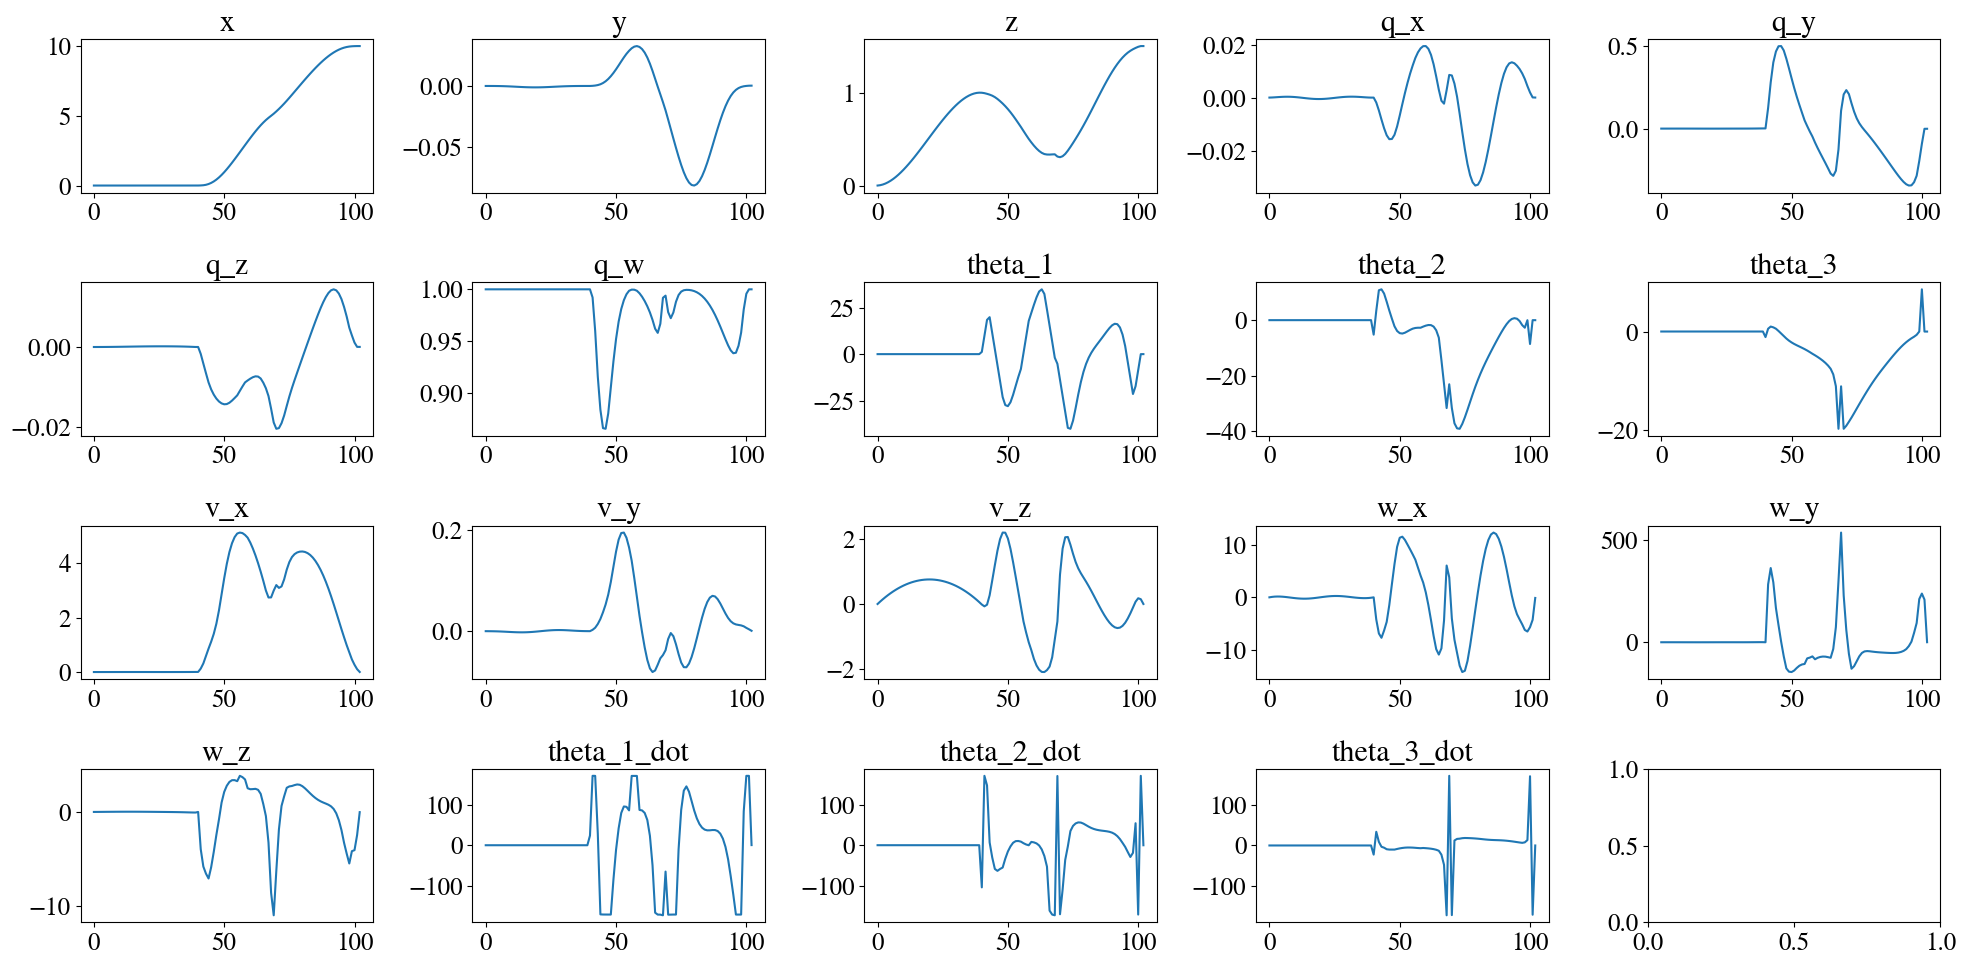

In [4]:
xs_new = np.vstack(solver.xs).T  # 将xs从StdVec_VectorX转换为numpy array
# 创建一个4行5列的plot
row = 4
col = 5
fig, axes = plt.subplots(row, col, figsize=(20, 10))
rad_to_deg = 57.3  # 弧度转角度
rad_to_deg_list = [7, 8, 9, 13, 14, 15, 16, 17, 18]
title_list_1 = ['x', 'y', 'z', 'q_x', 'q_y', 'q_z', 'q_w', 'theta_1', 'theta_2', 'theta_3', 'v_x', 'v_y', 'v_z', 'w_x', 'w_y', 'w_z', 'theta_1_dot', 'theta_2_dot', 'theta_3_dot']
# 遍历每个子图，并进行绘制
for i in range(xs_new.shape[0]):
    ax = axes[i // 5, i % 5]  # 获取当前的子图
    if i in rad_to_deg_list:
        ax.plot(np.rad2deg(xs_new[i, :]))
    else:
        ax.plot(xs_new[i, :])  # 绘制当前子图的数据
    ax.set_title(title_list_1[i])  # 设置当前子图的标题

# 调整子图之间的间距
plt.tight_layout()

### 关于状态量
为什么状态量是19个呢
在创建模型的时候，使用了pinocchio::JointModelFreeFlyer()，这样子实现的floating base的q是7维向量，前3个是在世界坐标系的坐标向量，后4个是在世界坐标系的四元数，四元数的顺序是 (x,y,z,w)，计算的v是6维向量，分别是在local坐标系中表示的速度和角速度，加速度a同理

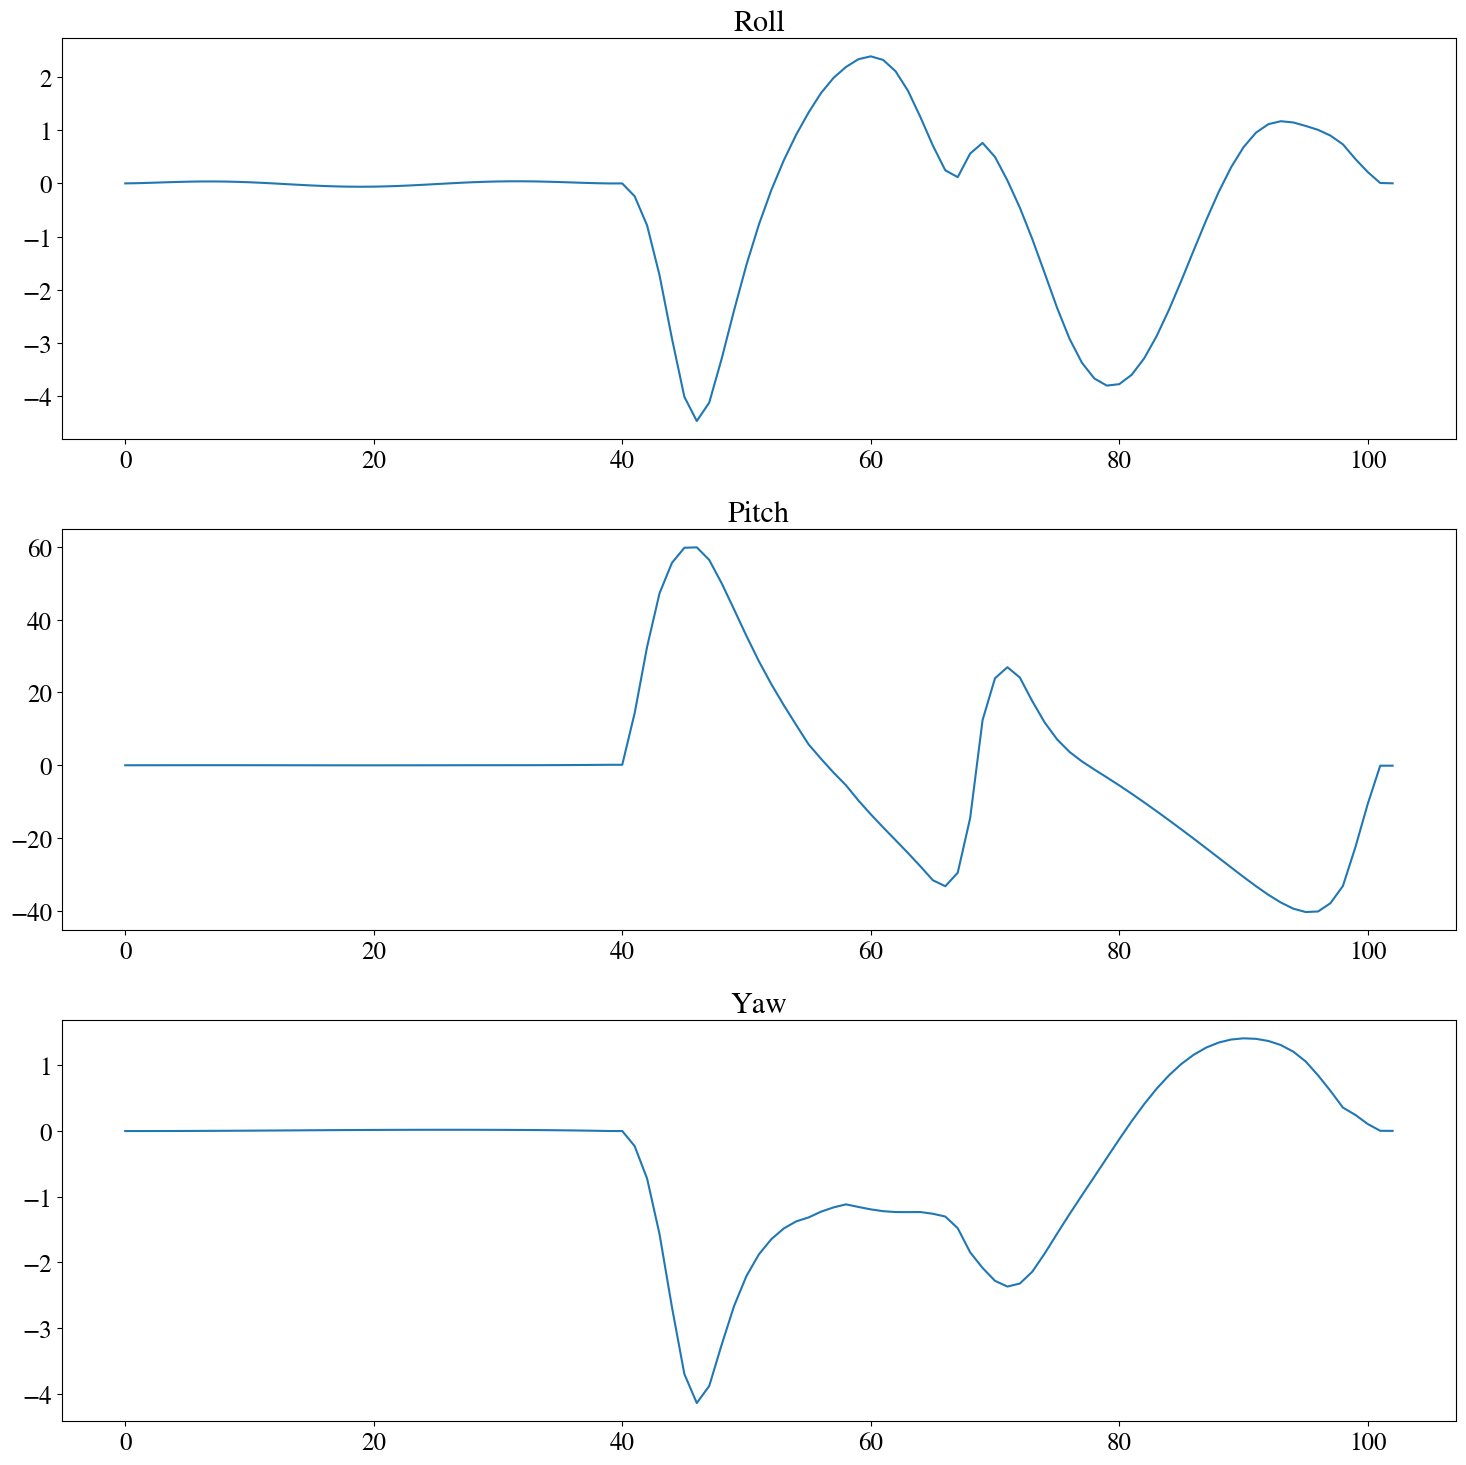

In [5]:


quaternions = xs_new[3:7, :].T

# 创建旋转对象，注意传入四元数的顺序为 [x, y, z, w]
rotation = R.from_quat(quaternions)

# 将旋转对象转换为欧拉角 (假设顺序为 'xyz')
euler_angles = rotation.as_euler('xyz', degrees=True)

title = ['Roll', 'Pitch', 'Yaw']

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
for i in range(3):
    ax = axes[i]
    ax.plot(euler_angles[:, i])
    ax.set_title(title[i])
    
# 调整子图之间的间距
plt.tight_layout()

### 控制器求解

In [6]:
# 定义mpc控制器
if mpcName == 'rail':
    mpcController = eagle_mpc.RailMpc(
        solver.xs, dt,
        "/home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/mpc/" + robotName + "_mpc.yaml")
elif mpcName == 'weighted':
    mpcController = eagle_mpc.WeightedMpc(
        trajectory, dt,
        "/home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/mpc/" + robotName + "_mpc.yaml")
else:
    mpcController = eagle_mpc.CarrotMpc(
        trajectory, solver.xs, dt,  # trajectory duration 2000ms, dt=50ms 
        "/home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/mpc/" + robotName + "_mpc.yaml")

mpcController.updateProblem(0)
mpcController.solver.solve(solver.xs[:mpcController.problem.T + 1], solver.us[:mpcController.problem.T])  # problem.T=29 所以一共30个时间步
mpcController.solver.convergence_init = 1e-3
# mpcController.solver.th_stop_gaps = 1e-2

dtSimulator = 1  # 设置仿真环境的ms
simulator = AerialSimulator(mpcController.robot_model, mpcController.platform_params, dtSimulator, solver.xs[0])
t = 0
updateTime = []
solveTime = []
print(problem.T)  # 40 属于trajectory的problem 因为trajectory有2000ms，每50ms一个时间步，所以一共有40个时间步
print(int(problem.T * dt * 1.2))

control_interval = 10   # 设置控制量的间隔 相当于10ms更新一次控制量 也就是100hz

for i in range(0, int(problem.T * dt * 1.2)):  # hover中，problem.T=405，所以一共有40*0*1.2=2400ms 为什么需要这么多时间步？ 对于hover问题
    print(i)
    
    # 更新mpc问题
    if i % control_interval == 0:
        mpcController.problem.x0 = simulator.states[-1]  #! 从simulator中获得当前状态
        start = time.time()
        # At t=4330 it turns carrot terminal model to false
        mpcController.updateProblem(int(t))  #! 可以更新当前是哪个stage
        end = time.time()
        updateTime.append(end - start)  # 记录更新时间
        start = time.time()
        print("Time stamp: ", t)
        mpcController.solver.solve(mpcController.solver.xs, mpcController.solver.us, mpcController.iters)   #! 解决mpc问题
        end = time.time()
        solveTime.append(end - start)  # 记录求解时间
        print("Solver time: ", end - start)
        control = np.copy(mpcController.solver.us_squash[0])
    
    # 仿真器仿真
    simulator.simulateStep(control)
    t += dtSimulator  # 每次增加仿真的时间步长

Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.
Deprecated ActuationModelMultiCopterBase: Use constructor without n_rotors.


[EAGLE_MPC INFO]: Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/mpc/hexacopter370_flying_arm_3_mpc.yaml
[EAGLE_MPC INFO]: Parsing /home/helei/catkin_ams/src/eagle_mpc_ros/eagle_mpc_yaml/multicopter/hexacopter370.yaml
[EAGLE_MPC INFO]: Number of rotors: 6
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.99889e+00  5.76000e-01  5.86500e+00  1.00000e-09  1.00000e-09   1.0000     1
   1  4.99889e+00  5.49057e-07  5.91698e-06  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  5.28837e+00  5.47388e-02  8.28859e-03  1.00000e-09  1.00000e-09   1.0000     1
   1  5.28837e+00  5.83524e-09  9.41681e-08  1.00000e-09  1.00000e-09   1.0000     1
102
6120
0
Time stamp:  0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  4.99889e+00  5.79087e-02  8.29837e-03  1.00000e-09  1.00000e-09   1.0000     1
   1  4.99889e+00  5.09730e-08  5.16187e-07  1.00000e-09  1.00000e-09   

### 输出控制指令

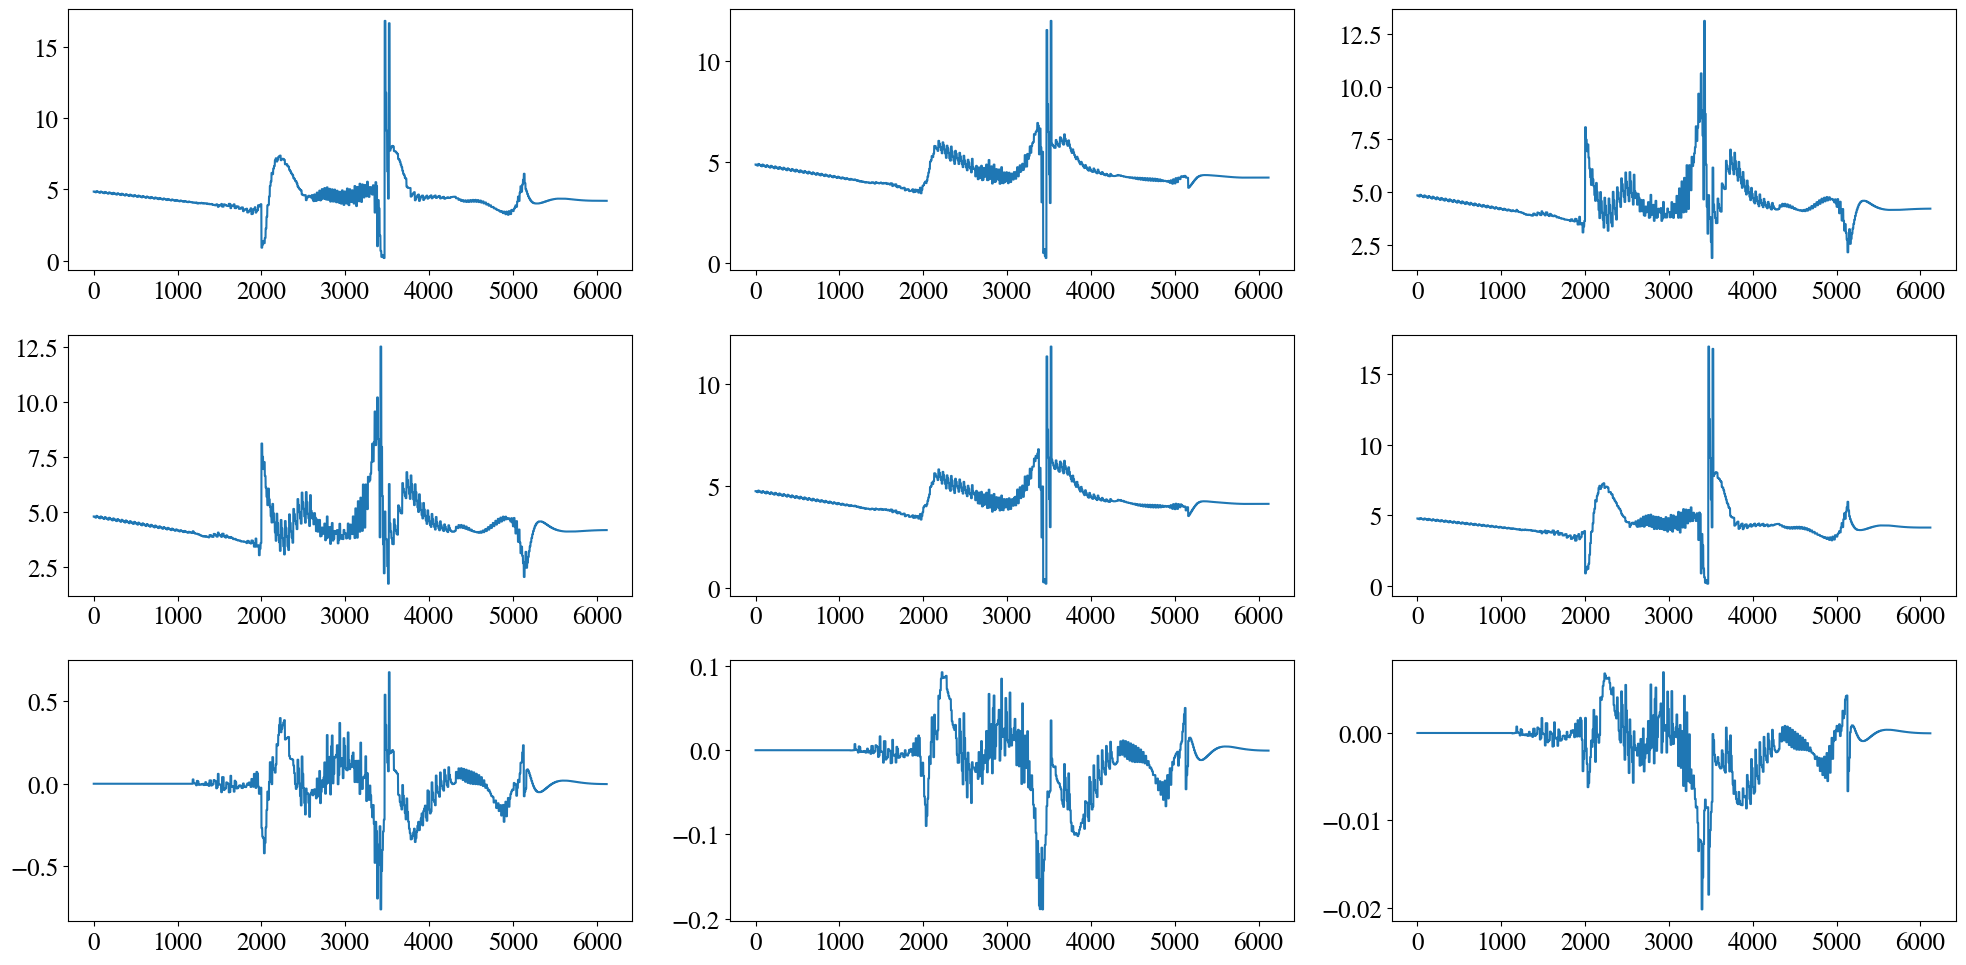

In [7]:
us_plot_mpc = np.vstack(simulator.controls).T  # 对记录的控制量进行转置

row = 3
col = 3
fig, axes = plt.subplots(row, col, figsize=(20, 10))

title_list_1 = ['x', 'y', 'z', 'q_x', 'q_y', 'q_z', 'q_w', 'theta_1', 'theta_2', 'theta_3', 'v_x', 'v_y', 'v_z', 'w_x', 'w_y', 'w_z', 'theta_1_dot', 'theta_2_dot', 'theta_3_dot']
# 遍历每个子图，并进行绘制
for i in range(us_plot_mpc.shape[0]):
    ax = axes[i // row, i % col]  # 获取当前的子图
    ax.plot(us_plot_mpc[i, :])  # 绘制当前子图的数据
    # ax.set_title(title_list_1[i])  # 设置当前子图的标题

# 调整子图之间的间距
plt.tight_layout()

### 查看控制效果

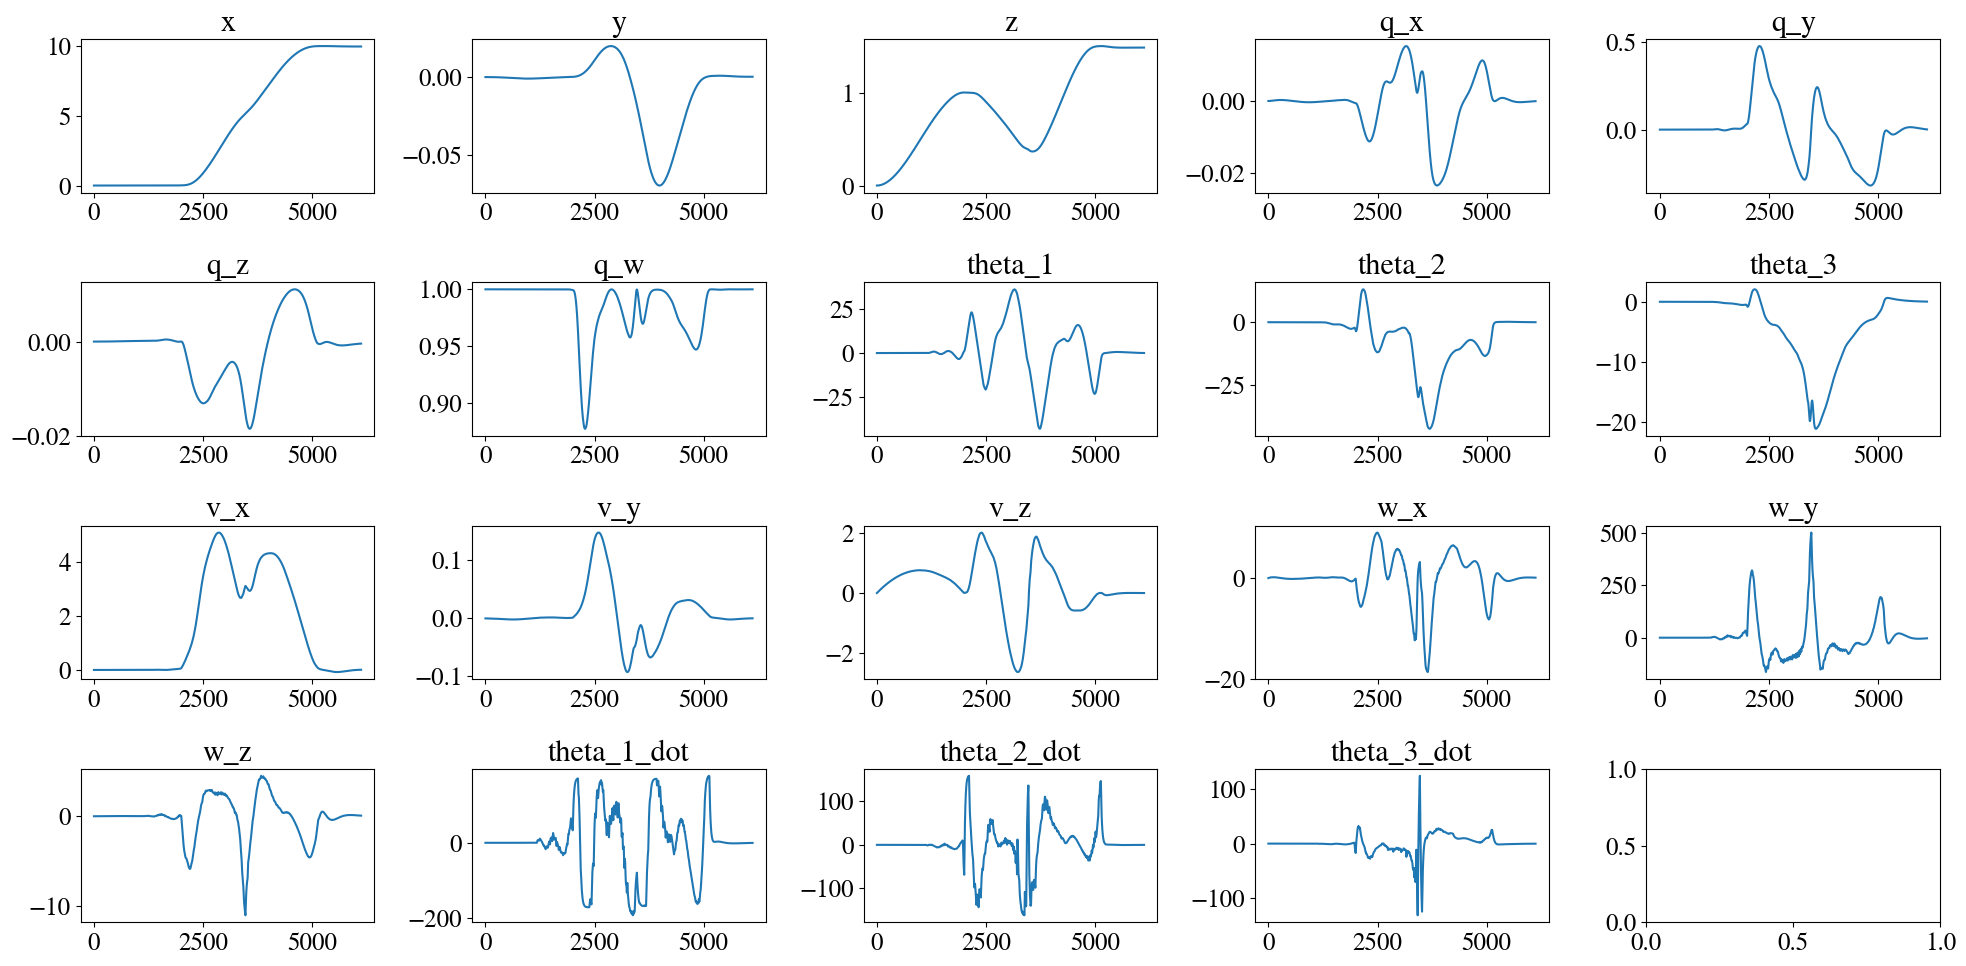

In [8]:
states = np.vstack(simulator.states).T
# 创建一个4行5列的plot
row = 4
col = 5
fig, axes = plt.subplots(row, col, figsize=(20, 10))
rad_to_deg_list = [7, 8, 9, 13, 14, 15, 16, 17, 18]
title_list_1 = ['x', 'y', 'z', 'q_x', 'q_y', 'q_z', 'q_w', 'theta_1', 'theta_2', 'theta_3', 'v_x', 'v_y', 'v_z', 'w_x', 'w_y', 'w_z', 'theta_1_dot', 'theta_2_dot', 'theta_3_dot']
# 遍历每个子图，并进行绘制
for i in range(states.shape[0]):
    ax = axes[i // 5, i % 5]  # 获取当前的子图
    if i in rad_to_deg_list:
        # ax.plot(np.rad2deg(xs_new[i, :]))
        ax.plot(np.rad2deg(states[i, :]))
    else:
        # ax.plot(xs_new[i, :])
        ax.plot(states[i, :])  # 绘制当前子图的数据
    ax.set_title(title_list_1[i])  # 设置当前子图的标题

# 调整子图之间的间距
plt.tight_layout()

### 创建控制效果对比图

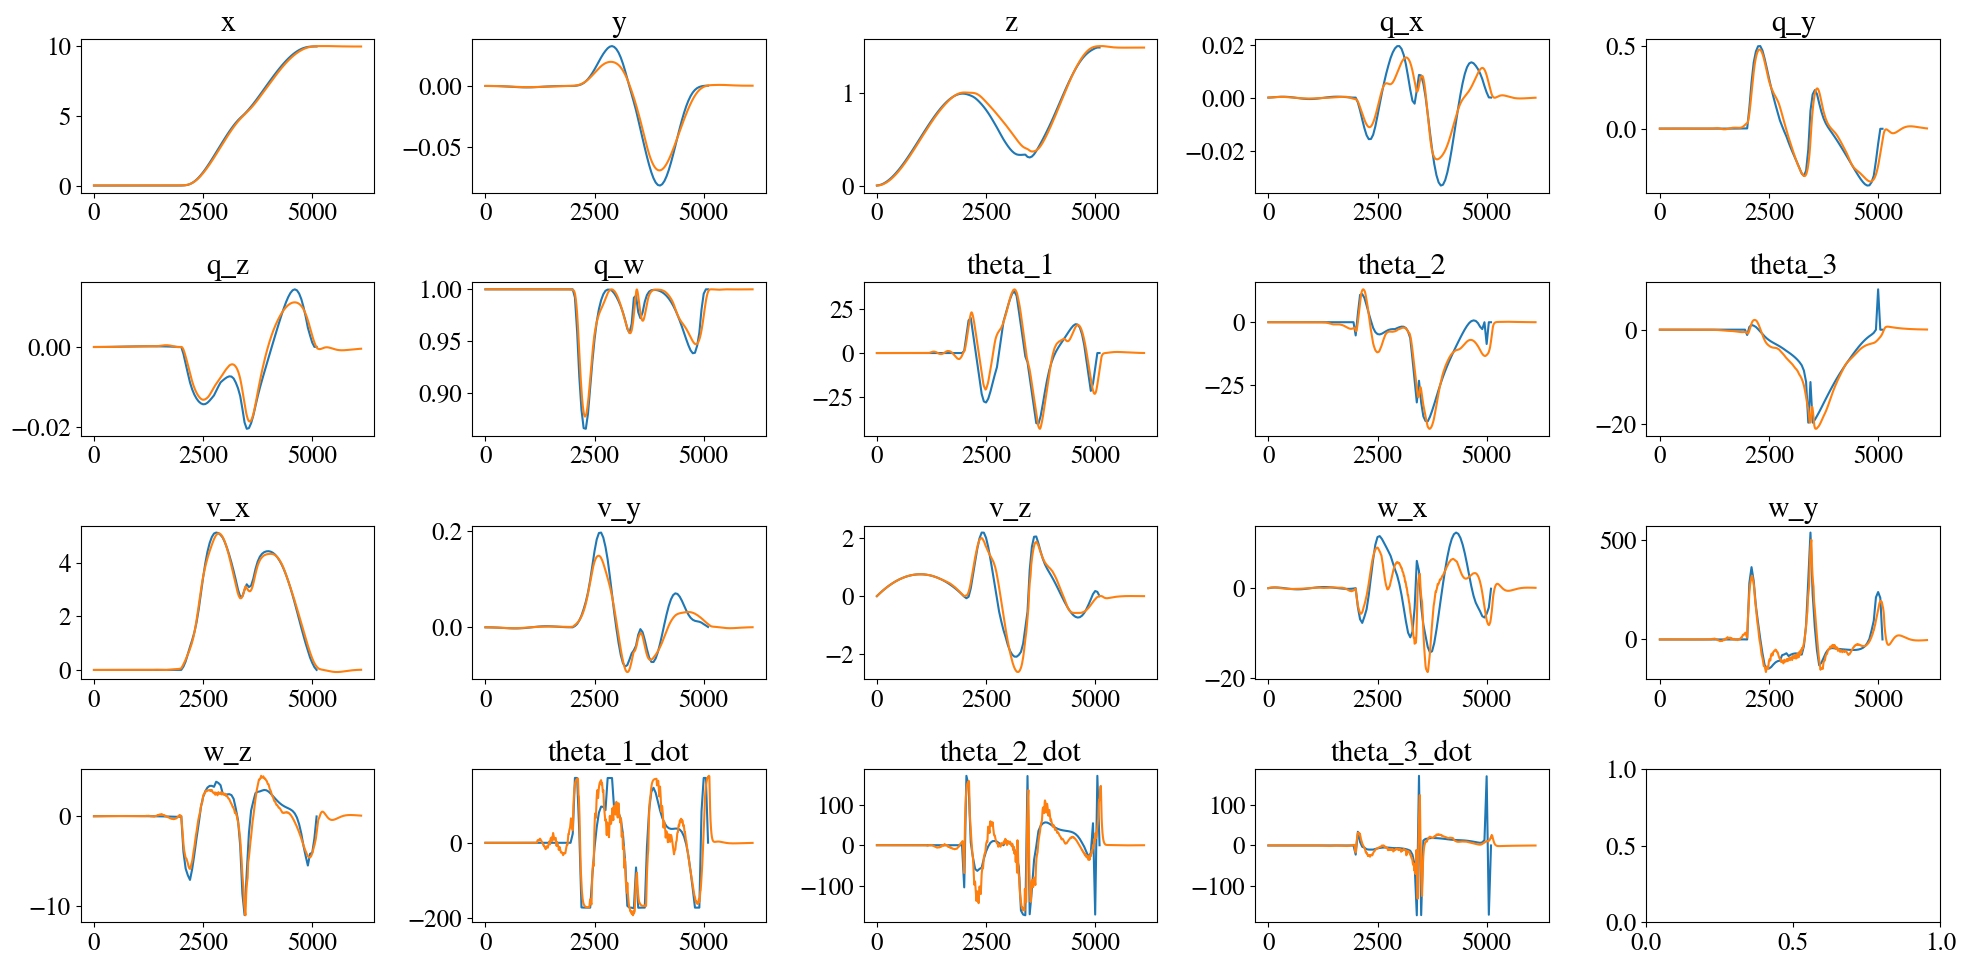

In [9]:
states = np.vstack(simulator.states).T
# 创建一个4行5列的plot
row = 4
col = 5
fig, axes = plt.subplots(row, col, figsize=(20, 10))
rad_to_deg_list = [7, 8, 9, 13, 14, 15, 16, 17, 18]
title_list_1 = ['x', 'y', 'z', 'q_x', 'q_y', 'q_z', 'q_w', 'theta_1', 'theta_2', 'theta_3', 'v_x', 'v_y', 'v_z', 'w_x', 'w_y', 'w_z', 'theta_1_dot', 'theta_2_dot', 'theta_3_dot']
# 遍历每个子图，并进行绘制
time_target = np.arange(0, 5101, 50)
for i in range(states.shape[0]):
    ax = axes[i // 5, i % 5]  # 获取当前的子图
    if i in rad_to_deg_list:
        ax.plot(time_target, np.rad2deg(xs_new[i, :]))
        ax.plot(np.rad2deg(states[i, :]))
    else:
        ax.plot(time_target, xs_new[i, :])
        ax.plot(states[i, :])  # 绘制当前子图的数据
    ax.set_title(title_list_1[i])  # 设置当前子图的标题

# 调整子图之间的间距
plt.tight_layout()

### 查看姿态控制效果

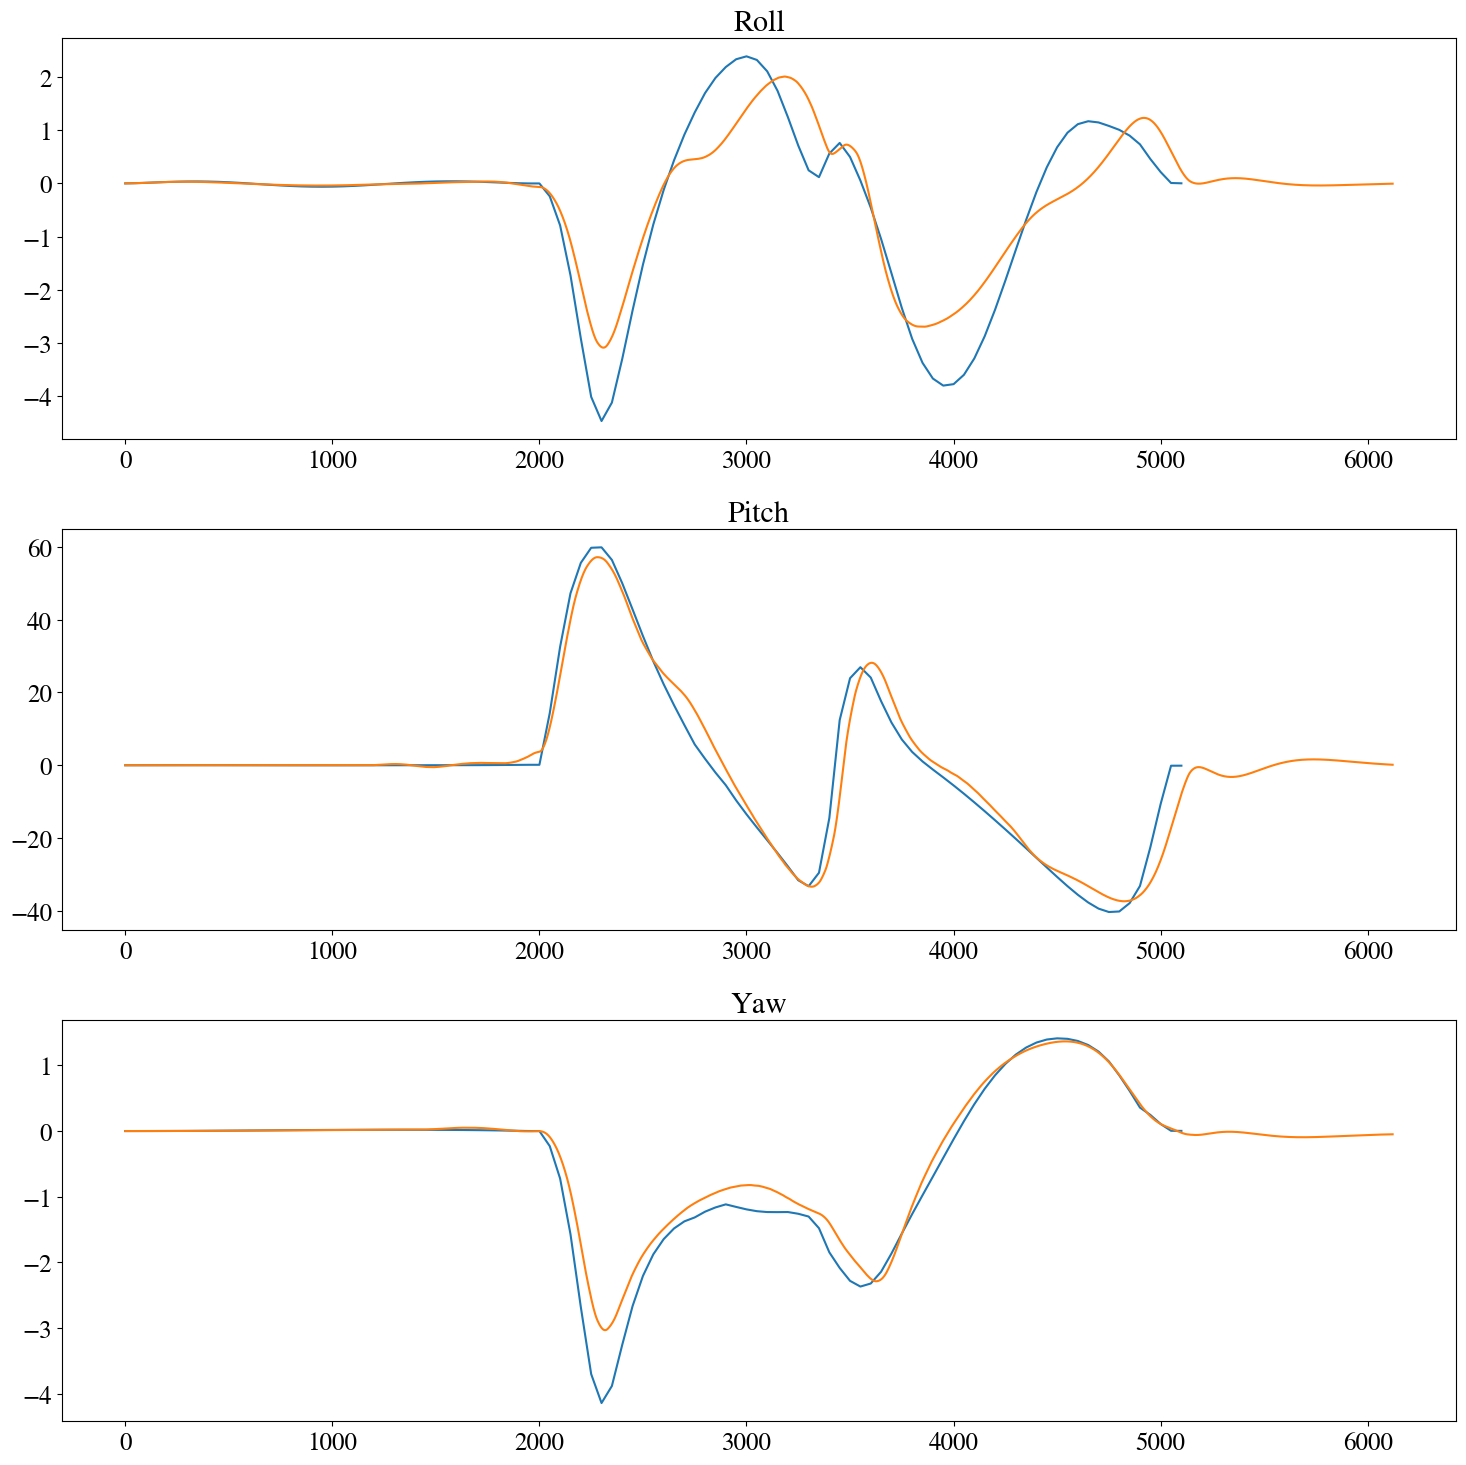

In [14]:

quaternions_state = states[3:7, :].T

# 创建旋转对象，注意传入四元数的顺序为 [x, y, z, w]
rotation_state = R.from_quat(quaternions_state)

# 将旋转对象转换为欧拉角 (假设顺序为 'xyz')
euler_angles_state = rotation_state.as_euler('xyz', degrees=True)

title = ['Roll', 'Pitch', 'Yaw']

time_target = np.arange(0, 5101, 50)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
for i in range(3):
    ax = axes[i]
    ax.plot(time_target, euler_angles[:, i])
    ax.plot(euler_angles_state[:, i])
    ax.set_title(title[i])
    
# 调整子图之间的间距
plt.tight_layout()